# **Library Import**

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_squared_error
from scipy.signal import convolve
from scipy.special import wofz
from scipy.special import voigt_profile
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# **Data Initialization**

It is important, beforehand, to confirm whether the columns in the data table are separated by spaces or by the tab character *(Tab)*, and also whether the decimal places are separated by a comma or a period.


## Pressure and Current

In [2]:
Pressao = 4.5
Corrente = 100

## The Data File is in Wavelenght or Wavenumber?

In [3]:
Comp_de_Onda = True #True for wavelenght|| False for wavenumber

## Initialize the Ratio vs Electronic Temperature table


In [4]:
arquivo = "RxTe.dat" #Table with the digitalized data from the table R x Te
dados_digitalizados = pd.read_csv(arquivo, delimiter=" ", decimal=",", header=None) #Adjust according to the file

#" " -> Space || "\t" -> Tab
#"," -> Comma || "." -> Point

## Initialize the Experimental Data of a Spectrum

In [5]:
arquivo = f"{Corrente}mA.txt"  #Table with the experimental data of the spectrum

if Comp_de_Onda:
  dados_experimento = pd.read_csv(arquivo, delimiter="\t", decimal=",", header=None, names=["Comprimento_de_Onda", "Intensidade"]) #Adjust according to the file
else:
  dados_experimento = pd.read_csv(arquivo, delimiter=" ", decimal=".", header=None, names=["Numero_de_Onda", "Intensidade"]) #Adjust according to the file

#" " -> Space || "\t" -> Tab
#"," -> Comma || "." -> Point

## Plot of the Experimental Spectrum

### Full Spectrum

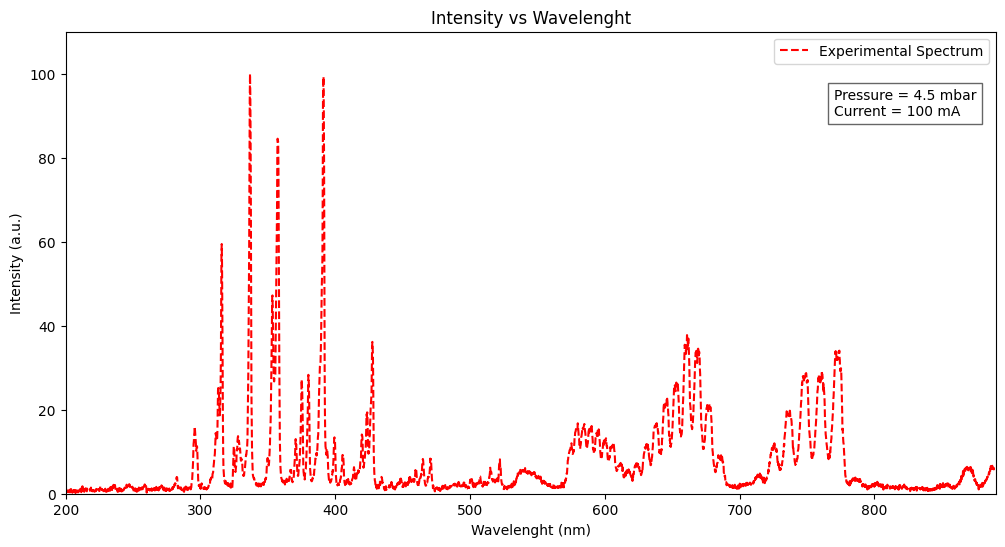

In [6]:
#Split columns (1ª: wavelenght (nm), 2ª: intensity)
if Comp_de_Onda:
  x2 = dados_experimento.iloc[:, 0].values  #First columm (Wavelenght)
else:
  x2 =  1e+7 / dados_experimento.iloc[:, 0].astype(float).values  #First columm (Wavenumber)
y2 = dados_experimento.iloc[:, 1].values  #Second columm

#Normalizing the experimental spectrum to the maximum intensity = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

#Plotting the spectrum
plt.figure(figsize=(12, 6))
plt.plot(x2, y2, label='Experimental Spectrum', color='r', linestyle='--')

#Axis name
if Comp_de_Onda:
  plt.xlabel('Wavelenght (nm)')
else:
  plt.xlabel('Wavelenght (nm)')
plt.ylabel('Intensity (a.u.)')

#Adjust according to the data type
if Comp_de_Onda:
  plt.title('Intensity vs Wavelenght')
else:
  plt.title('Intensity vs Wavelenght')

#Limit the region of the graph
plt.xlim(200, 890)
plt.ylim(0, 110)
plt.legend()

#Data
valores = (
    f"Pressure = {Pressao:.1f} mbar\n"
    f"Current = {Corrente} mA"
)

#Legend showing the variables
plt.text(770, max(y2) * 0.900, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

### Cropped Spectrum


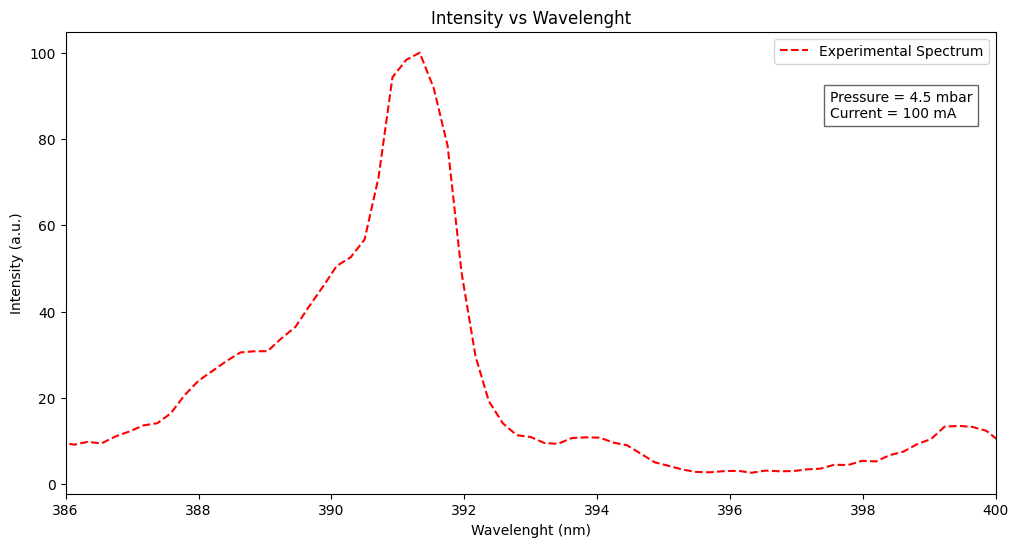

In [7]:
#Split columns (1ª: wavelenght (nm), 2ª: intensity)
if Comp_de_Onda:
  x2 = dados_experimento.iloc[:, 0].values  #First columm (Wavelenght)
else:
  x2 =  1e+7 / dados_experimento.iloc[:, 0].astype(float).values  #First columm (Wavenumber)
y2 = dados_experimento.iloc[:, 1].values  #Second columm

#Filter Experimental Spectrum data for the range from 385 nm to 401 nm
mask2 = (x2 >= 385) & (x2 <= 401)
x2 = (x2[mask2] + 0) #Sum for callibration, if the x axis is decalibrated
y2 = y2[mask2]

#Normalizing the experimental spectrum to the maximum intensity = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

#Plotting the spectrum
plt.figure(figsize=(12, 6))
plt.plot(x2, y2, label='Experimental Spectrum', color='r', linestyle='--')

#Axis name
if Comp_de_Onda:
  plt.xlabel('Wavelenght (nm)')
else:
  plt.xlabel('Wavelenght (nm)')
plt.ylabel('Intensity (a.u.)')

#Adjust according to the data type
if Comp_de_Onda:
  plt.title('Intensity vs Wavelenght')
else:
  plt.title('Intensity vs Wavelenght')

#Limit the graph in this region
plt.xlim(386, 400)
plt.legend()

#Data
valores = (
    f"Pressure = {Pressao:.1f} mbar\n"
    f"Current = {Corrente} mA"
)

#Legend showing the variables
plt.text(397.5, max(y2) * 0.850, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

# **Algorithm for Estimating the Electronic Temperature**

Method described in the book by [André Ricard](https://books.google.com.br/books/about/Reactive_Plasmas.html?id=fpfsSAAACAAJ&redir_esc=y) and applied by [N. Britun](https://iopscience.iop.org/article/10.1088/0022-3727/40/4/016), which uses the ratio of the intensities of the $0-0$ band of the *First Negative System* of $N_2^+$, located at $391.44$ $nm$, to the $2-5$ band of the *Second Positive System* of $N_2$, located at $394.30$ $nm$. This ratio is written as

*   $R = \frac{I (391.44 \hspace{1mm} nm)}{I (393.40 \hspace{1mm} nm)}$.

As one of the fundamental assumptions is that the plasma follows a Maxwellian distribution, this method was used as a *first approximation* for the Electronic Temperature of the negative glow of the Hollow Cathode, which occurs in a **strongly non-Maxwellian** regime.

## Interpolation of the Digitized Data

We used the [WebPlot Digitizer](https://automeris.io/) tool to digitize the graph of the Ratio as a function of the Electronic Temperature found in the book by [André Ricard](https://books.google.com.br/books/about/Reactive_Plasmas.html?id=fpfsSAAACAAJ&redir_esc=y). With this, we applied the code below to:

*   Work with Electronic Temperature as a function of the Ratio;
*   Generate a (cubic) interpolation to retrieve the data that was not digitized;
*   Generate a plot comparing the digitized data with the interpolation.

Thus, we will have a function called *Temperatura_Eletronica* that receives a Ratio value and returns an estimate of the Electronic Temperature.


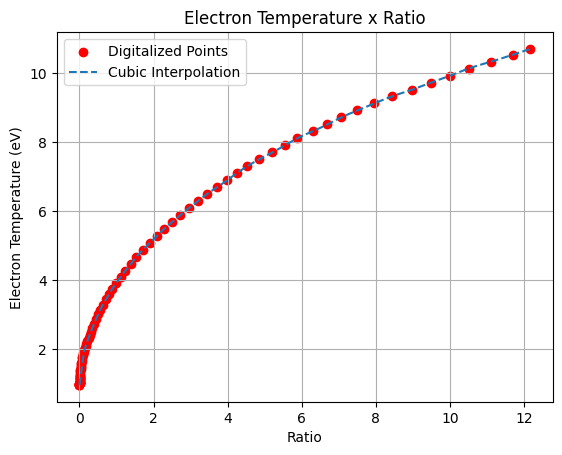

In [8]:
#Graph with Te x R
R = dados_digitalizados.iloc[:, 1].values  #Ratio || Second Columm
TE = dados_digitalizados.iloc[:, 0].values  #Electronic Temperature || First Columm

#Cubic interpolation function
Temperatura_Eletronica = interp1d(R, TE, kind='cubic')

#Points generated to plot the interpolation
R_intermediario = np.linspace(min(R), max(R), 100)
TE_intermediario = Temperatura_Eletronica(R_intermediario)

#Original Graph (Digitalized)
plt.scatter(R, TE, color='red', label='Digitalized Points')

#Interpolated curve
plt.plot(R_intermediario, TE_intermediario, label='Cubic Interpolation', linestyle='--')

plt.legend()
plt.xlabel("Ratio")
plt.ylabel("Electron Temperature (eV)")
plt.title("Electron Temperature x Ratio")
plt.grid()
plt.show()

## Potential Fit to be used as an estimate for Ratios greater than $12.1720$

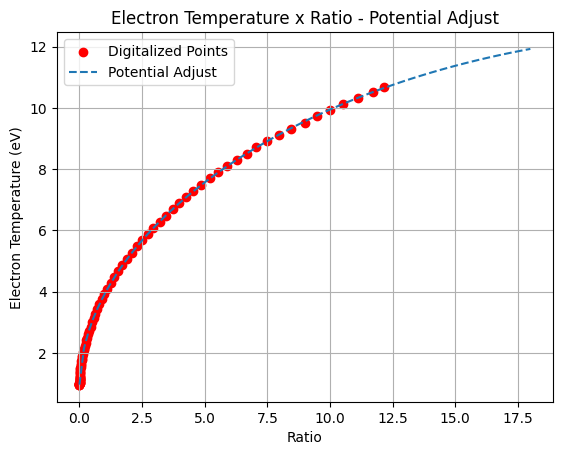

In [9]:
def Ajuste_Potencial(x, a, b, c, d, e):
    return a * (x ** b) + c + d * x + e * (x ** 2)

parametros, _ = curve_fit(Ajuste_Potencial, R, TE, p0=[1, 0.5, 1, 0.1, 0.01], maxfev=10000)

#Points generated to plot the interpolation
R_intermediario = np.linspace(min(R), 18, 100)
TE_ajustado = Ajuste_Potencial(R_intermediario, *parametros)

#Original Graph (Digitalized)
plt.scatter(R, TE, color='red', label='Digitalized Points')

#Interpolated curve
plt.plot(R_intermediario, TE_ajustado, label='Potential Adjust', linestyle='--')

plt.legend()
plt.xlabel("Ratio")
plt.ylabel("Electron Temperature (eV)")
plt.title("Electron Temperature x Ratio - Potential Adjust")
plt.grid()
plt.show()

## Calculation of the Uncertainty Associated with the Electronic Temperature

We used the first set of values $(Te, R)$ from the original graph as the exact values. With this, we applied $R$ to the interpolated function to estimate an uncertainty associated with the interpolation.

In [10]:
R_exato = 0.001  #Exact vallue of the Ration
TE_exato = 1  #Exact vallue of the Electronic Temperature

#Cálculo da Interpolação
TE_ajustado = Ajuste_Potencial(R_exato, *parametros)
TE_interpolado = Temperatura_Eletronica(R_exato)

#Cálculo da Incerteza
erro_ajustado = abs(TE_exato - TE_ajustado)
erro_interpolado = 2 * abs(TE_exato - TE_interpolado)

print(f"Temperatura Eletrônica Real: {TE_exato} eV")
print(f"Temperatura Eletrônica Estimada: {TE_ajustado:.4f} eV")
print(f"Temperatura Eletrônica Estimada: {TE_interpolado:.4f} eV")
print(f"Erro do ajuste estimado: {erro_ajustado:.4f} eV")
print(f"Erro da interpolação estimado: {erro_interpolado:.4f} eV")

Temperatura Eletrônica Real: 1 eV
Temperatura Eletrônica Estimada: 0.9672 eV
Temperatura Eletrônica Estimada: 0.9687 eV
Erro do ajuste estimado: 0.0328 eV
Erro da interpolação estimado: 0.0626 eV


## Calculation of the Real Ratio from an Experimental Spectrum

In this section, we read an experimental spectrum whose data are arranged in pairs $(\mbox{Wavelength}, \mbox{Intensity})$ for the calculation of the real Ratio between the intensities. It is important to note that, since the real spectrum has low resolution, the wavelengths are not exactly those expected but have a slight discrepancy.


In [11]:
if Comp_de_Onda:
  #Wavelenghts of interest
  V1 = 391.33
  V2 = 394.25

  #Assignment of intensities
  I1 = dados_experimento.loc[dados_experimento["Comprimento_de_Onda"] == V1, "Intensidade"].values
  I2 = dados_experimento.loc[dados_experimento["Comprimento_de_Onda"] == V2, "Intensidade"].values
else:
  #Wavenumbers of interest
  V1 = 25540.13597 #cm-1
  V2 = 25361.85904 #cm-1

  #Assignment of intensities
  I1 = dados_experimento.loc[dados_experimento["Numero_de_Onda"] == V1, "Intensidade"].values
  I2 = dados_experimento.loc[dados_experimento["Numero_de_Onda"] == V2, "Intensidade"].values

#Verification of the values
if I1.size > 0 and I2.size > 0:
    I1 = I1[0]
    I2 = I2[0]

    Razao = I1 / I2 if I2 != 0 else float("nan")

    if Comp_de_Onda:
      print(f"Intensidade em {V1} nm: {I1}")
      print(f"Intensidade em {V2} nm: {I2}")
    else:
      print(f"Intensidade em {V1} cm-1: {I1}")
      print(f"Intensidade em {V2} cm-1: {I2}")

    print(f"Razão: {Razao:.4f}")
else:
    print("Erro: Um ou ambos valores não foram encontrados na tabela.")

Intensidade em 391.33 nm: 20799.17
Intensidade em 394.25 nm: 1998.82
Razão: 10.4057


## Estimation of the Electronic Temperature, in *Kelvin*

Here we apply the interpolation to estimate the Electronic Temperature from the experiment. It is important to note that the calculated value is in $eV$, the usual unit in Molecular Physics. However, for the comparative method, we need to convert it to *Kelvin*, using the approximation

*   $1 eV ≈ 11604 K$.


In [12]:
if Razao <= 12.172033905486556:
  Te_eV = Temperatura_Eletronica(Razao)
else:
  Te_eV = Ajuste_Potencial(Razao, *parametros)

Te = Te_eV * 11604 #1eV is approx 11604K

print(f"Temperatura Eletrônica em eV: {Te_eV:.4f} eV")
print(f"Temperatura Eletrônica em Kelvins: {Te:.4f} K")

Temperatura Eletrônica em eV: 10.0852 eV
Temperatura Eletrônica em Kelvins: 117028.5207 K


# **Parameters and Constants**

Here we list the parameters of interest, such as temperatures, fundamental constants, and spectroscopic constants necessary for the calculations.


## Temperatures

The three temperatures are in *Kelvin (K)*. As pointed out by [N. Britun](https://iopscience.iop.org/article/10.1088/0022-3727/40/4/016), we should expect the inequality

*   $T_{el} > T_v > T_r$,

which is a classical result in Molecular Physics.

In [13]:
TEMP_ELE = Te #Electronic Temperature
TEMP_V = 3700 #Vibrational Temperature | Manual Adjust
TEMP_R = 600 #Rotational Temperature | Manual Adjust

## Molecular Parameters

Some parameters for the intensity calculations. Here we provide an estimate for $\alpha$, which describes the synthetic spectrum profile along with the Vibrational and Rotational Temperatures. We also set equal and arbitrary values for the concentrations of $N_2$ and $N_2^+$, since the intensities will be normalized later and $\alpha$ already includes the ratio $[N_2^+] / [N_2]$.

In [14]:
alpha = 0.45 #Manual Adjust

C_N2 = 1 #Since the intensity is normalized, I can use an arbitrary value.
C_N2_Mais = 1 #1 to avoid propagation of uncertainties. The ratio will be defined by alpha.

## Fundamental Constants

The constants are in the CGS unit system (centimeter, gram, seconds).


In [15]:
h = 6.626176e-27 # Planck's Constant  || erg.s
c = 29_979_245_800 # Light Velocity || cm/s
k = 1.380649e-16 # Boltzmann's Constant || erg/K

## Spectroscopic Constants of $N_2$: Second Positive System $C^3\Pi_u^+ \to B^3\Pi_g^+$

Subscript $1$ denotes the upper state $'$, and subscript $2$ denotes the lower state $''$. The constants were taken from the book by [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22).


### Upper State $C^3\Pi_u^+$

In [16]:
t1 = 89147.3 #Electronic Term

#Vibrational Constants
we1 = 2035.1
wexe1 = 17.08
weye1 = -2.15
weze1 = 0 #No data

#Equilibrium Rotational Constants
be_1 = 1.8259
ae_1 = 0.0197

### Lower State $ B^3\Pi_g^+ $

In [17]:
t2 = 59626.3 #Electronic Term

#Vibrational Constants
we2 = 1734.11
wexe2 = 14.47
weye2 = 0 #No data
weze2 = 0 #No data

#Equilibrium Rotational Constants
be_2 = 1.6380
ae_2 = 0.0184

### Dictionary with the Constant Parameters for the Transition $C^3\Pi_u^+ \to B^3\Pi_g^+$

SSP: Second Positive System


In [18]:
Quantidades_SSP = {
    #Electronic Terms
    't1': t1,  #Upper Electronic Term
    't2': t2,  #Lower Electronic Term

    #Temperatures
    'Tv': TEMP_V,
    'Tr': TEMP_R,

    #Vibrational Constants
    'we1': we1, 'wexe1': wexe1, 'weye1': weye1, 'weze1': weze1,
    'we2': we2, 'wexe2': wexe2, 'weye2': weye2, 'weze2': weze2,

    #Rotational Constants
    'be_1': be_1, 'ae_1': ae_1, 'be_2': be_2, 'ae_2': ae_2,

    #Other Values
    'Concentracao': C_N2,
    'h': h,  #Planck's Constant
    'c': c,  #Light Velocity
    'En': h * c * t1,  #Eletronic Energy
    'Lambda': 1,  #Lambda = 1 for N2
    'Alpha': alpha,
    'kTel': k * TEMP_ELE
}

#Function to dynamically calculate kTv and kTr
def atualizar_k(Quantidades):
    Quantidades['kTv'] = k * Quantidades['Tv']
    Quantidades['kTr'] = k * Quantidades['Tr']

#Initialization of kTv, kTr and kTel
atualizar_k(Quantidades_SSP)

## Spectroscopic Constants of $N_2^+$: First Negative System $B^2\Sigma_u^+ \to X^2\Sigma_g^+$

Subscript $1$ denotes the upper state $'$, and subscript $2$ denotes the lower state $''$. The constants were taken from the book by [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22). We will write the Electronic Terms as $T_n$ when citing them, as done by [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).


### Upper State $B^2\Sigma _u^+$

In [19]:
t1 = 25461.5

#Vibrational Constants
we1 = 2419.84
wexe1 = 23.19
weye1 = -0.5375
weze1 = 0 #No Data

#Equilibrium Rotational Constants
be_1 = 2.083
ae_1 = 0.0195

### Lower State $X^2\Sigma _g ^+$

In [20]:
t2 = 0 #Electronic Term

#Vibrational Constants
we2 = 2207.19
wexe2 = 16.136
weye2 = -0.04
weze2 = 0 #No Data

#Equilibrium Rotational Constants
be_2 = 1.932
ae_2 = 0.020

### Dictionary with the Constant Parameters for the Transition $B^2\Sigma_u^+ \to X^2\Sigma_g^+$

PSN: First Negative System

In [21]:
Quantidades_PSN = {
    #Electronic Terms
    't1': t1,  #Upper Electronic Term
    't2': t2,  #Lower Electronic Term

    #Temperatures
    'Tv': TEMP_V,
    'Tr': TEMP_R,

    #Vibrational Constants
    'we1': we1, 'wexe1': wexe1, 'weye1': weye1, 'weze1': weze1,
    'we2': we2, 'wexe2': wexe2, 'weye2': weye2, 'weze2': weze2,

    #Rotational Constants
    'be_1': be_1, 'ae_1': ae_1, 'be_2': be_2, 'ae_2': ae_2,

    #Other Values
    'Concentracao': C_N2_Mais,
    'h': h,  #Planck's Constant
    'c': c,  #Light Velocity
    'En': h * c * t1,  #Electronic Energy
    'Lambda': 0,  #Lambda = 0 for N2+
    'Alpha': alpha,
    'kTel': k * TEMP_ELE
}

#Function to dynamically calculate kTv and kTr
def atualizar_k(Quantidades):
    Quantidades['kTv'] = k * Quantidades['Tv']
    Quantidades['kTr'] = k * Quantidades['Tr']

#Initialization of kTv, kTr and kTel
atualizar_k(Quantidades_PSN)

# **Functions for Numerical Calculations**

This group of cells will be used to write all the functions that will be utilized during the execution of the code.

**Note:** Lambda $(\Lambda)$ represents the angular momentum of the electrons, disregarding spin, around the internuclear axis of the molecule. For $\Sigma \to \Sigma$ transitions, as in the case of the First Negative System of $N_2^+$, $\Lambda = 0$. For $\Pi \to \Pi$ transitions, as in the case of the Second Positive System of $N_2$, $\Lambda = 1$.


## Parameters for the Rotational Terms

Considering the molecule rotating and vibrating at the same time, we must consider the rotational terms depending on the vibration. Hence, the need to use the *vibrational quantum number* $v$. In order, the parameters are given by:

*   $B_v = B_e - \alpha_e \left(v+\frac{1}{2}\right) + \dots$, which is an average value of the constant $B$ when vibration is considered. $B_e$ represents the reciprocal of the moment of inertia multiplied by a factor,

*   $D_e = \frac{4B_e^3}{\omega_e^2}$, which causes the rotational lines to come closer,

*   $\beta_e = D_e \left(\frac{8\omega_e x_e}{\omega_e} - \frac{5 \alpha_e}{B_e} - \frac{\alpha_e^2 \omega_e}{24 B_e^3} \right)$, a fitting constant,

*   $D_v = D_e + \beta_e \left(v+\frac{1}{2}\right) + \dots$, representing the influence of the Centrifugal Force,

*   $Y = \frac{A}{B_v}$, which measures the strength of the spin coupling with the internuclear axis,

*   $Z_1 = \Lambda ^2 Y (Y - 4) + \frac{4}{3} + 4J(J+1)$, used in the Budo terms (N2),

*   $Z_2 = \frac{1}{3 Z_1} \left[\Lambda ^2 Y (Y - 1) - \frac{4}{9} - 2J(J+1)\right]$, used in the Budo terms (N2).


In [22]:
def Bv(Be, ae, v): # Bv is an average value of the constant B when vibration is considered
  return (Be - ae * (v + 0.5)) # Be represents the reciprocal of the moment of inertia multiplied by a factor

def De(Be, we): # De causes the rotational lines to come closer
  return ((4 * (Be ** 3)) / (we ** 2))

def beta_e(ae, wexe, Be, we): # A fitting constant
  return (De(Be, we) * ( ((8 * wexe) / (we)) - ((5 * ae) / (Be)) - (((ae ** 2) * we) / (24 * (Be ** 3))) ))

def Dv(ae, wexe, Be, we, v): # Represents the influence of the Centrifugal Force
  return (De(Be, we) + beta_e(ae, wexe, Be, we) * (v + 0.5))

def Y(A, Be, ae, v): # Measures the strength of the Spin Coupling with the internuclear axis
  return (A / Bv(Be, ae, v))

def Z1(J, A, Be, ae, v, Lambda): # Used in the Budo terms (N2)
  return ((Lambda ** 2) * Y(A, Be, ae, v) * (Y(A, Be, ae, v) - 4) + 4.0/3.0 + 4 * J * (J + 1))

def Z2(J, A, Be, ae, v, Lambda): # Used in the Budo terms (N2)
  return ((1/(3*Z1(J, A, Be, ae, v, Lambda))) * ((Lambda ** 2) * Y(A, Be, ae, v) * (Y(A, Be, ae, v) - 1) - 4.0/9.0 - 2 * J * (J + 1)))


## Budó Rotational Terms for $N_2$ (Triplet)

The variable *term* indicates each line of the triplet. These terms refer to the spin decoupling for the intermediate case between Hund's cases (a) and (b), obtained by [A. Budó](https://doi.org/10.1007/BF01341523). The Terms are

*   $F_1(J) = B_v[J(J+1) - \sqrt{Z_1} - 2 Z_2] - D_v(J - \frac{1}{2})^4$,

*   $F_2(J) = B_v[J(J+1) + 4 Z_2] - D_v(J + \frac{1}{2})^4$,

*   $F_3(J) = B_v[J(J+1) + \sqrt{Z_1} - 2 Z_2] - D_v(J + \frac{3}{2})^4$.


In [23]:
def termoRotacional_Budo(J, A, Be, ae, v, Lambda, we, wexe, termo):
  if termo == 1:
    return Bv(Be, ae, v) * (J * (J + 1) - mt.sqrt(Z1(J, A, Be, ae, v, Lambda)) - 2 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J - 0.5) ** 4)

  if termo == 2:
    return Bv(Be, ae, v) * (J * (J + 1) + 4 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J + 0.5) ** 4)

  if termo == 3:
    return Bv(Be, ae, v) * (J * (J + 1) + mt.sqrt(Z1(J, A, Be, ae, v, Lambda)) - 2 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J + 3.0/2.0) ** 4)


## Mulliken Rotational Terms for $N_2^+$ (Doublet)

The variable *term* indicates each line of the doublet. These terms refer to *Hund's case (b)*, present in [Mulliken](https://doi.org/10.1103/RevModPhys.2.60), and are given by

*   $F_1(K) = B_v K(K+1) + \frac{1}{2} \gamma K - D_v K^2 (K + 1)^2$,

*   $F_2(K) = B_v K(K+1) - \frac{1}{2} \gamma (K + 1) - D_v K^2 (K + 1)^2$,

Here, **K** represents the *total angular momentum excluding spin* and **J** represents the *total angular momentum including spin*. $F_1(K)$ refers to components with $J = K + \frac{1}{2}$ and $F_2(K)$ refers to those with $J = K - \frac{1}{2}$. The splitting constant $\gamma$ is small compared to $B_v$.


In [24]:
def termoRotacional_Mulliken(K, Be, ae, v, gamma, we, wexe, termo): #For N2+, doublet terms
  if termo == 1:
    return Bv(Be, ae, v) * (K) * (K + 1) + (0.5 * gamma) * (K) - Dv(ae, wexe, Be, we, v) * ((K) ** 2) * ((K + 1) ** 2)

  if termo == 2:
    return Bv(Be, ae, v) * (K) * (K + 1) - (0.5 * gamma) * (K + 1) - Dv(ae, wexe, Be, we, v) * ((K) ** 2) * ((K + 1) ** 2)


## Vibrational Term (Vibrating Rotator)

We implemented up to $\omega_e x_e$, although we have not found sufficient data to include this constant in the program. The Vibrational Term is expressed as

*   $G(v) = (v + \frac{1}{2}) \omega_e - (v + \frac{1}{2})^2 \omega_e x_e + (v + \frac{1}{2})^3 \omega_e y_e - (v + \frac{1}{2})^4 \omega_e y_e + \cdots$.


In [25]:
def termoVibracional(v, we, wexe, weye, weze):
    return ((v + 0.5) * we) - (((v + 0.5) ** 2) * wexe) + (((v + 0.5) ** 3) * weye) - (((v + 0.5) ** 4) * weze)

## Hönl-London Factors

We have different factors for $N_2$ and for $N_2^+$.


### Factors for $N_2$

These are the generic factors listed in [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22) for $\Delta \Lambda = 0$ (that is, both electronic levels have the same value of $\Lambda$). The formulas are

*   $S_J^R = \frac{(J' + \Lambda)(J' - \Lambda)}{J'}$,

*   $S_J^Q = \frac{(2J' + 1) \Lambda^2}{J' (J' + 1)}$,

*   $S_J^P = \frac{(J' + 1 + \Lambda)(J' + 1 - \Lambda)}{J' + 1}$.


In [26]:
def SJ_R(J, Lambda): #For the R Branch
    return ((J + Lambda) * (J - Lambda)) / J

def SJ_Q(J, Lambda): #For the Q Branch
    return ((2 * J + 1) * (Lambda ** 2)) / (J * (J + 1))

def SJ_P(J, Lambda): #For the P Branch
    return ((J + 1 + Lambda) * (J + 1 - Lambda)) / (J + 1)

### Factors for $N_2^+$

These are the specific factors for $^2\Sigma \to ^2\Sigma$ transitions, found in [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22), given by

*   $S_J^R = \frac{(J'' + 1)^2 - \frac{1}{4}}{J'' + 1}$,

*   $S_J^Q = \frac{2J'' + 1}{4 J'' (J'' + 1)}$,

*   $S_J^P = \frac{J''^2 - \frac{1}{4}}{J''}$.


In [27]:
def SJ_R_N2_Mais(J, Lambda): #For the R Branch
  return ((((J + 1) ** 2) - 1.0/4.0) / (J + 1))

def SJ_Q_N2_Mais(J, Lambda): #For the Q Branch
  return ((2 * J + 1) / (4 * J * (J + 1)))

def SJ_P_N2_Mais(J, Lambda): #For the P Branch
  return ((J ** 2 - 1.0/4.0) / J)

## Calculation of Partition Functions

Here we define the Electronic, Vibrational, and Rotational Partition Functions, along with the term $G_0(v)$ used in the calculation of the Vibrational Partition Function. The Electronic part was taken from the book by [M. Capitelli](https://ui.adsabs.harvard.edu/abs/2005ESAST.246.....C/abstract), while the Vibrational and Rotational parts come from [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22). The term $G_0(v)$ is

*   $G_0(v) = \omega_0 v - \omega_0 x_0 v^2 + \omega_0 y_0 v^3 + \cdots$,

where the constants are

*   $\omega_0 = \omega_e - \omega_e x_e + \frac{3}{4} \omega_e y_e + \cdots$,

*   $\omega_0 x_0 = \omega_e x_e - \frac{3}{2} \omega_e y_e + \cdots$,

*   $\omega_0 y_0 = \omega_e y_e + \cdots$.

The Partition Functions are given by

*   $Q_{el} = \frac{1}{\sigma} \sum_n^{n_{max}} g_n e^{- E_{el}(n) / kT_{el}}$,

*   $Q_v = 1 + e^{-G_0(1) hc / kT_v} + e^{-G_0(2) hc / kT_v} + \dots$,

*   $Q_r = \sum_J^{J_{max}} (2J + 1) e^{- B J (J + 1) hc / kT_r}$,

where $\sigma = 2$ for homonuclear molecules and $g_n$ is the statistical weight. The Rotational Partition Function follows the Rigid Rotor model. For the implementation of the Electronic Partition Function of $N_2^+$, we consider the first three electronic states, in descending order of energy: $B^2\Sigma_u^+$, $A^2\Pi_u$, and $X^2\Sigma_g^+$ (ground state). The Electronic Terms of $B^2\Sigma_u^+$ and $X^2\Sigma_g^+$ (which is zero) were taken from [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22), while the electronic term of $A^2\Pi_u$ was taken from [K. P. Hube](https://link.springer.com/book/10.1007/978-1-4757-0961-2).

### **Statistical Weight**

The values of the statistical weights can be derived from the theory presented by [D. S. Villars](https://pubs.acs.org/doi/10.1021/cr60040a003), who states that the statistical weight is given by

* $w_{el} = (2S + 1) g_{\Lambda}$,

where

* $g_\Lambda = 2$ if $\Lambda > 0$, and $g_\Lambda = 1$ if $\Lambda = 0$.

Since $S = 1/2$ for the three electronic states, $\Lambda = 0$ for $\Sigma$ states and $\Lambda = 1$ for $\Pi$ states, then the statistical weight is

* **2** for $B^2\Sigma_u^+$,

* **4** for $A^2\Pi_u$,

* **2** for $X^2\Sigma_g^+$.

**Note:** The Partition Function is only considered for $N_2^+$ because we assume only the ground state of $N_2$ is significantly populated, as suggested by condition (2) in André Ricard’s method.


In [28]:
# Vibrational term considering the term at vibrational level v=0 as zero
def G0(v, we, wexe, weye):
    return ((we - wexe + (3.0/4.0) * weye) * v) - ((wexe - (3.0/2.0) * weye) * (v ** 2)) + (weye * (v ** 3))

## Electronic Partition Function for N2+
def FdeParticaoE_N2_Mais(kTel):
    return (1.0/2.0) * ( (2 * np.exp(- ((25461.5 * h * c) / (kTel)))) + (4 * np.exp(- ((9166.95 * h * c) / (kTel)))) + (2 * np.exp(- ((0 * h * c) / (kTel)))) )

# Vibrational Partition Function
def FdeParticaoV(we, wexe, weye, h, c, kTv, v_max):
    Qv = 1
    for v in range(v_max):
      if v == 0:
        continue
      Qv += np.exp(- ((G0(v, we, wexe, weye) * h * c) / (kTv)))
    return Qv

# Rotational Partition Function
def FdeParticaoR(j_max, B, h, c, kTr): # Considering as Rigid Rotor
    Qr = 1
    for j in range(j_max):
      if j == 0:
        continue
      Qr += (2*j + 1) * np.exp( - (B * (j*(j + 1)) * h * c) / (kTr))
    return Qr

## Functions for Calculating Intensities

We define the terms $C_{N_2}$ and $C_{N_2^+}$ within the same function *C_Termo*, where:

*   $C_{N_2} = \frac{8 \pi^3 c}{9} [N_2] e^{-(E_{n'} / k T_{el})}$,

*   $C_{N_2^+} = \frac{16 \pi^3 c}{9} [N_2^+] e^{-(E_{n'} / k T_{el})}$,

where the superscript $'$ denotes the upper electronic state, and $E_{n'} = hcT_n$ (with $T_n$ being the electronic term and $T_{el}$ the electronic temperature). $[N_2]$ is the concentration of neutral nitrogen, and $[N_2^+]$ is the concentration of ionized nitrogen.

Thus, the *Absolute Intensity of the Rotational Lines* is given by:

*   $ϵ_{N_2} = C_{N_2} \frac{\bar{R_e^2} q_{v'v''} e^{-(E_{v'}/kT_v)} S_{J'J''} \sigma^4 e^{-(E_{J'}/kT_r)}}{Q_{N_2}(T_{el}, T_v, T_r)}$,

*   $ϵ_{N_2^+} = C_{N_2^+} \frac{\bar{R_e^2} q_{v'v''} e^{-(E_{v'}/kT_v)} S_{J'J''} \sigma^4 e^{-(E_{J'}/kT_r)}}{Q_{N_2^+}(T_{el}, T_v, T_r)} \cdot 3\phi_{p'}$,

where $Q_{N_2}$ and $Q_{N_2^+}$ are the partition functions for the neutral molecule and the ion, respectively. The parameter $\phi_{p'}$ equals $\frac{1}{3}$ for even values of $J'$, and $\frac{2}{3}$ for odd values of $J'$.

The function *Calcular_Intensidade* computes the intensity of a rotational line (noting that the spectrum consists of rotational lines corresponding to different vibrational and electronic transitions). It applies the corresponding Hönl-London factor, selects the appropriate $\phi$ value for $N_2^+$ lines, and finally multiplies the inverse of the *Alpha* factor to the $N_2$ lines, following the normalization proposed in the article by [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).


In [29]:
#This function represents C from the article, which is used in the absolute intensity formula
def C_Termo(Luz, En1, kTel, Concentracao, Lambda):
    if Lambda == 1: #1 for N2
      return ((8 * (np.pi ** 3) * Luz) / 9.0) * Concentracao * (np.exp(- (En1 / (kTel))))
    if Lambda == 0: #0 for N2+
      return ((16 * (np.pi ** 3) * Luz) / 9.0) * Concentracao * (np.exp(- (En1 / (kTel))))

#This function is the Absolute Intensity of Rotational Lines, as proposed in the article
def Epsilon(C, M_de_Transicao_Eletronica, q, Ev1, kTv, S, Sigma_ul, EJ1, kTr, F_de_Particao, Phi, Lambda):
    if Lambda == 1: #1 for N2
      return C * ((M_de_Transicao_Eletronica * q * (np.exp(- (Ev1 / (kTv)))) * S * (Sigma_ul ** 4) * (np.exp(- (EJ1 / (kTr))))) / F_de_Particao)
    if Lambda == 0: #0 for N2+
      return C * ((M_de_Transicao_Eletronica * q * (np.exp(- (Ev1 / (kTv)))) * S * (Sigma_ul ** 4) * (np.exp(- (EJ1 / (kTr))))) / F_de_Particao) * 3 * Phi

#This function receives the parameters and applies the Hönl-London factors for each line;
#it also computes the Phi factor for N2+ lines, calculates the line intensity, and multiplies
#by the Alpha factor in case of N2 lines.
def Calcular_Intensidade(row, **kwargs):
    #Applies the corresponding Hönl-London factor to the line
    if row['rama'] == 'Q':
      S = row['SQ']
    elif row['rama'] == 'R':
      S = row['SR']
    elif row['rama'] == 'P':
      S = row['SP']
    else: #In case an error occurs
      S = 0

    phi = 0

    if kwargs.get('Lambda', -1) == 0: #N2+
      if row['k1'] % 2 == 0:
        phi = 1.0/3.0
      else:
        phi = 2.0/3.0

    #Here we call the Epsilon function
    intensidade = Epsilon(
      C = kwargs.get('Const', 0),
      M_de_Transicao_Eletronica = kwargs.get('Re2', 0),
      q = kwargs.get('qvv', 0),
      Ev1 = kwargs.get('Ev', 0),
      kTv = kwargs.get('kTv', 0),
      S = S,
      Sigma_ul = row['sigma'],
      EJ1 = (h * c * row['F1']),
      kTr = kwargs.get('kTr', 0),
      F_de_Particao = kwargs.get('Q', 0),
      Phi = phi,
      Lambda = kwargs.get('Lambda', -1)
    )

    #As stated in Nassar's article, the N2 lines are normalized by multiplying by the inverse of Alpha.
    if kwargs.get('Lambda', -1) == 0: #0 for N2+
      return intensidade
    if kwargs.get('Lambda', -1) == 1: #1 for N2
      return (intensidade / kwargs.get('Alpha', 0))


## Function to Calculate the Ratio $[N_2^+] / [N_2]$

By estimating $Alpha$ based on an experimental spectrum, and knowing the Electronic Temperature and the Partition Functions, we can apply the equation below to obtain an estimate of the ratio $[N_2^+] / [N_2]$ between the concentrations.


In [30]:
def Razao_das_Concentracoes(Alpha, QN2, QN2Mais, kTel):
  return (Alpha / 2) * (QN2Mais / QN2) * np.exp(((3.1 - 11.1) * (1.6 * 1e-19)) / (kTel))

## Function to Calculate the Partition Function

In this equation, knowing that by the *Born-Oppenheimer Approximation*, we can approximate the Total Partition Function as

*   $Q = Q_e Q_v Q_r$,

We apply the Partition Functions for the calculation considering the populations of the levels as follows:

* $Q_e$ is $1$ for $N_2$, for the reasons we have already discussed, and we apply the previously defined equation for $N_2^+$.

* To calculate $Q_v$, we sum the Vibrational Partition Function of the Upper Electronic State with the Vibrational Partition Function of the Lower Electronic State. We consider the maximum values of $v$ found in the article by [Laiz R. Ventura](https://doi.org/10.1016/j.jqsrt.2019.106645) for $N_2$ and by [Laiz R. Ventura](https://doi.org/10.1016/j.jms.2024.111902) for $N_2^+$ as the maximum $v$ for the summation in each Electronic State.  

* For $Q_r$, we apply the same reasoning as we did for $Q_v$. The value of $j_{max}$ used will be numerically equal to the value of $k_{max}$, which we will define in the next function. This choice was made for convenience, since the quantum number $K$ is not defined for the Rigid Rotor, but its maximum value is a good approximation for $J$.


In [31]:
def Calcular_Q(j_max, **kwargs):

  if kwargs.get('Lambda', -1) == 1: #N2
    Qe = 1
    Qv = FdeParticaoV(kwargs.get('we1', 0), kwargs.get('wexe1', 0), kwargs.get('weye1', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 4) * FdeParticaoV(kwargs.get('we2', 0), kwargs.get('wexe2', 0), kwargs.get('weye2', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 11)
  if kwargs.get('Lambda', -1) == 0: #N2+
    Qe = FdeParticaoE_N2_Mais(kwargs.get('kTel', 0))
    Qv = FdeParticaoV(kwargs.get('we1', 0), kwargs.get('wexe1', 0), kwargs.get('weye1', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 6) * FdeParticaoV(kwargs.get('we2', 0), kwargs.get('wexe2', 0), kwargs.get('weye2', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 9)

  Qr = FdeParticaoR(j_max, kwargs.get('be_1'), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTr', 0)) * FdeParticaoR(j_max, kwargs.get('be_2'), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTr', 0))

  return Qe * Qv * Qr


## Function to Calculate the Transitions

This is the main function of the program, where the principles of Molecular Physics are applied to calculate the transitions.

The total energy of the molecule is:

$hc \sigma = E_{elect} + E_{vib} + E_{rot}$

Dividing both sides by $hc$, we obtain the electronic term $T$, vibrational term $G$, and rotational term $F$:

$\sigma = T + G(v) + F(J)$

When a transition occurs, the molecule starts in an upper state and ends in a lower state. Thus, the wavenumber associated with the emitted energy corresponds to the energy difference between these two states. Writing this difference in terms of spectroscopic terms, we obtain:

$\sigma = \frac{E'}{hc} - \frac{E''}{hc}$

$\sigma = [T' + G'(v) + F'(J)] - [T'' + G''(v) + F''(J)]$

Therefore, the wavenumber associated with a transition is:

$\sigma = (T' - T'') + [G'(v) - G''(v)] + [F'(J)- F''(J)]$

We then need to iterate over $v$ and $J$ to perform this calculation and determine the wavenumber, taking into account the number $K$.


In [32]:
#Function fo calculation of the transitions
def Calcular_Transicoes(A_1, A_2, gamma_1, gamma_2, v1, v2, qvv, Re2, **kwargs):
    transicoes = {"k1": [] ,"j1":[] ,'j2': [] , "v1": [], 'v2':[], 'SQ':[], 'SR':[], 'SP':[], 'rama':[] ,'sigma': [], 'F1': [], 'intensidade': []}

    G1 = termoVibracional(v = v1, we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), weye = kwargs.get('weye1', 0), weze = kwargs.get('weze1', 0))
    G2 = termoVibracional(v = v2, we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), weye = kwargs.get('weye2', 0), weze = kwargs.get('weze2', 0))

    Ev = kwargs.get('h', 0) * kwargs.get('c', 0) * G1

    Const = C_Termo(Luz = kwargs.get('c', 0), En1 = kwargs.get('En', 0), kTel = kwargs.get('kTel', 0), Concentracao = kwargs.get('Concentracao', 0), Lambda = kwargs.get('Lambda', -1))

    sigma_0 = ((kwargs.get('t1', 0)) - (kwargs.get('t2', 0))) + (G1 - G2) #Zero line of the band

    k_max = 50

    for k1 in range(k_max):
        for k2 in range(k1 + k_max):

            SJ_q = None
            SJ_r = None
            SJ_p = None

            delta_k = k1 - k2
            F1 = 0
            F2 = 0

            match kwargs.get('Lambda', -1):
              case 1: #N2
                if k < 16: #Hund's (a) case
                  j1 = k1
                  j2 = k2

                  delta_j = j1 - j2

                  if delta_j == 0 or abs(delta_j) == 1:

                      if j1 == 0 or j2 == 0:
                          continue

                      if delta_j == 0:
                        rama = 'Q'
                        SJ_q = SJ_Q(J = j1, Lambda = kwargs.get('Lambda', -1))
                      elif delta_j == 1:
                        rama = 'R'
                        SJ_r = SJ_R(J = j1, Lambda = kwargs.get('Lambda', -1))
                      else:
                        rama = 'P'
                        SJ_p = SJ_P(J = j1, Lambda = kwargs.get('Lambda', -1))

                      intensidade = 0

                      for multipleto in range(1, 4):

                        transicoes['k1'].append(k1)
                        transicoes['j1'].append(j1)
                        transicoes['j2'].append(j2)
                        transicoes['v1'].append(v1)
                        transicoes['v2'].append(v2)
                        transicoes['SQ'].append(SJ_q)
                        transicoes['SR'].append(SJ_r)
                        transicoes['SP'].append(SJ_p)

                        F1 = termoRotacional_Budo(J = j1, A = A_1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto)
                        F2 = termoRotacional_Budo(J = j2, A = A_2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto)

                        sigmaFINAL = sigma_0 + (F1 - F2)

                        transicoes['sigma'].append(sigmaFINAL)
                        transicoes['rama'].append(rama)
                        transicoes['F1'].append(F1)
                        transicoes['intensidade'].append(intensidade)

                else: #Hund's (b) case
                  if delta_k == 0 or abs(delta_k) == 1:

                    for multipleto_1 in range(1, 4):
                      for multipleto_2 in range(1, 4):

                        if multipleto_1 == 1:
                          j1 = k1 + 1
                        if multipleto_2 == 1:
                          j2 = k2 + 1
                        if multipleto_1 == 2:
                          j1 = k1
                        if multipleto_2 == 2:
                          j2 = k2
                        if multipleto_1 == 3:
                          j1 = k1 - 1
                        if multipleto_2 == 3:
                          j2 = k2 - 1

                        delta_j = j1 - j2

                        if delta_j == 0 or abs(delta_j) == 1:

                          if delta_k == 0 and delta_j == 0:
                            rama = 'Q'
                            SJ_q = SJ_Q(J = j1, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == 1 and delta_j == 1:
                            rama = 'R'
                            SJ_r = SJ_R(J = j1, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == -1 and delta_j == -1:
                            rama = 'P'
                            SJ_p = SJ_P(J = j1, Lambda = kwargs.get('Lambda', -1))

                          intensidade = 0

                          transicoes['k1'].append(k1)
                          transicoes['j1'].append(j1)
                          transicoes['j2'].append(j2)
                          transicoes['v1'].append(v1)
                          transicoes['v2'].append(v2)
                          transicoes['SQ'].append(SJ_q)
                          transicoes['SR'].append(SJ_r)
                          transicoes['SP'].append(SJ_p)

                          F1 = termoRotacional_Budo(J = j1, A = A_1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto_1)
                          F2 = termoRotacional_Budo(J = j2, A = A_2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto_2)

                          sigmaFINAL = sigma_0 + (F1 - F2)

                          transicoes['sigma'].append(sigmaFINAL)
                          transicoes['rama'].append(rama)
                          transicoes['F1'].append(F1)
                          transicoes['intensidade'].append(intensidade)

              ####################################################
              case 0: #N2+
                if abs(delta_k) == 1:

                    for multipleto_1 in range(1, 3):
                      for multipleto_2 in range(1, 3):

                        if multipleto_1 == 1:
                          j1 = k1 + 0.5
                        if multipleto_2 == 1:
                          j2 = k2 + 0.5
                        if multipleto_1 == 2:
                          j1 = k1 - 0.5
                        if multipleto_2 == 2:
                          j2 = k2 - 0.5

                        delta_j = j1 - j2

                        if delta_j == 0 or abs(delta_j) == 1:

                          if delta_j == 0:
                            rama = 'Q'
                            SJ_q = SJ_Q_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == 1 and delta_j == 1:
                            rama = 'R'
                            SJ_r = SJ_R_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == -1 and delta_j == -1:
                            rama = 'P'
                            SJ_p = SJ_P_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))

                          intensidade = 0

                          transicoes['k1'].append(k1)
                          transicoes['j1'].append(j1)
                          transicoes['j2'].append(j2)
                          transicoes['v1'].append(v1)
                          transicoes['v2'].append(v2)
                          transicoes['SQ'].append(SJ_q)
                          transicoes['SR'].append(SJ_r)
                          transicoes['SP'].append(SJ_p)

                          F1 = termoRotacional_Mulliken(K = k1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, gamma = gamma_1, we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto_1)
                          F2 = termoRotacional_Mulliken(K = k2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, gamma = gamma_2, we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto_2)

                          sigmaFINAL = sigma_0 + (F1 - F2)

                          transicoes['sigma'].append(sigmaFINAL)
                          transicoes['rama'].append(rama)
                          transicoes['F1'].append(F1)
                          transicoes['intensidade'].append(intensidade)

    Q = Calcular_Q(k_max, **kwargs)

    Quantidades_Calcular_Intensidade = {'Lambda': kwargs.get('Lambda', -1), 'Const': Const, 'Re2': Re2, 'qvv': qvv, 'Ev': Ev, 'kTv': kwargs.get('kTv', 0), 'kTr': kwargs.get('kTr', 0), 'Q': Q, 'Alpha': kwargs.get('Alpha', 0)}

    transicoes = pd.DataFrame(transicoes)
    transicoes['intensidade'] = transicoes.apply(Calcular_Intensidade, axis=1, **Quantidades_Calcular_Intensidade)
    Quantidades_Calcular_Intensidade.clear

    return transicoes

## Voigt Profile Convolution

The Voigt Convolution combines the Gaussian profile and the Lorentzian profile. This convolution involves two important parameters, $\sigma$ and $\gamma$.

*   The parameter $\sigma$ refers to the Gaussian profile and is associated with *Instrumental (Doppler) Broadening* caused by limitations of the measurement instrument. The larger this parameter, the sharper the spectral peaks.

* The parameter $\gamma$ refers to the Lorentzian profile and is associated with *Natural (Collisional) Broadening*, which occurs due to intrinsic physical phenomena of atoms or molecules, such as the Heisenberg Uncertainty or collisions. The larger this parameter, the wider and more pronounced the tails of the peaks.

In the *Espectro_Sintetico* function, we calculate the Voigt Profile for each individual line, apply the calculated intensity, and add it to the total spectrum. It returns an ordered pair of wavenumber and intensity. For more details on the Voigt Function, see the review by [B. H. Armstrong](https://www.sciencedirect.com/science/article/abs/pii/002240736790057X?via%3Dihub).


In [33]:
def Espectro_Sintetico(Sigma, Gamma, Resolucao, Numero_de_Onda, Intensidades):
    #Generates the plot points
    pontos = int((max(Numero_de_Onda) - min(Numero_de_Onda)) / Resolucao) + 1
    x = np.linspace(min(Numero_de_Onda), max(Numero_de_Onda), pontos)

    #Initializes the synthetic spectrum as zero
    espectro_sintetico = np.zeros_like(x)

    #Calculates the profile of each line and adds it to the total spectrum
    for num_onda, intensidade in zip(Numero_de_Onda, Intensidades):
        curva_voigt = voigt_profile(x - num_onda, Sigma, Gamma) #Computes the profile for each line
        espectro_sintetico += intensidade * curva_voigt #Profile is multiplied by intensity and added to total spectrum

    #Returns the ordered pair (Wavenumber, Intensity)
    return x, espectro_sintetico


## Function to Calculate the Transitions and Apply the Convolution

The constants $A$ were taken from the article by [Laiz R. Ventura](https://doi.org/10.1016/j.jqsrt.2019.106645) for $N_2$.


In [34]:
def calcular_todas_transicoes(Sigma, Gamma, Resolucao, SSP, PSN):
    # Second Positive System
    # NOTE: Lambda = 1 means we will use N2
    transicoes1 = Calcular_Transicoes(A_1=38.544, A_2=42.023, gamma_1=0, gamma_2=0, v1=1, v2=4, qvv=0.110, Re2 = (1.124 ** 2), **SSP)
    transicoes2 = Calcular_Transicoes(A_1=37.757, A_2=41.955, gamma_1=0, gamma_2=0, v1=2, v2=5, qvv=0.139, Re2 = (1.119 ** 2), **SSP)
    transicoes3 = Calcular_Transicoes(A_1=36.634, A_2=41.883, gamma_1=0, gamma_2=0, v1=3, v2=6, qvv=0.131, Re2 = (1.132 ** 2), **SSP)
    # This transition was added only to improve the tail at lower wavelengths
    transicoes_ex1 = Calcular_Transicoes(A_1=34.826, A_2=41.809, gamma_1=0, gamma_2=0, v1=4, v2=7, qvv=0.101, Re2 = (1.093 ** 2), **SSP)

    # First Negative System
    # NOTE: Lambda = 0 means we will use N2+
    transicoes4 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.02069, gamma_2=0.00917, v1=0, v2=0, qvv=1, Re2 = 0.54, **PSN) #Found data for Re2 x qvv
    transicoes5 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.02025, gamma_2=0.00928, v1=1, v2=1, qvv=1, Re2 = 0.21, **PSN)
    # This transition was added only to improve the tail at lower wavelengths
    transicoes_ex2 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.00945, gamma_2=0.90683, v1=2, v2=2, qvv=1, Re2 = 0.06, **PSN)

    # Combine all transitions
    todas_transicoes = pd.concat([transicoes1, transicoes2, transicoes3, transicoes_ex1, transicoes4, transicoes5, transicoes_ex2])

    # Calculate synthetic spectrum
    Numero_de_Onda = todas_transicoes['sigma'].to_list()
    Intensidades = todas_transicoes['intensidade'].to_list()
    x, y = Espectro_Sintetico(Sigma=Sigma, Gamma=Gamma, Resolucao=Resolucao,
                              Numero_de_Onda=Numero_de_Onda, Intensidades=Intensidades)

    # Convert wavenumber to wavelength in cm
    comprimento_onda_cm = 1 / x
    # Convert wavelength to nm
    comprimento_onda_nm = comprimento_onda_cm * 1e7

    # Normalize the Synthetic Spectrum to maximum intensity = 100
    y = (y / np.max(y)) * 100

    # Uncomment to generate a plot distinguishing the three branches
    #sns.scatterplot(data = todas_transicoes, x='sigma',y='intensidade',hue='rama')

    return np.array(comprimento_onda_nm), np.array(y)


# **Calculation of the Different Transitions**

## Application of the calcular_todas_transicoes Function

Here we adjust the parameters ($\sigma$, $\gamma$, $Resolution$) of the Voigt Profile


In [35]:
Sigma = 23 # Instrumental Broadening (Dominant) | Manually Adjusted
Gamma = 12 # Natural Broadening (physical phenomenon) | Manually Adjusted
Resolucao = 10 # Manually Adjusted, high value for faster execution without significantly affecting the result

x, y = calcular_todas_transicoes(Sigma, Gamma, Resolucao, Quantidades_SSP, Quantidades_PSN)


## Synthetic Spectrum Plot in Wavelength


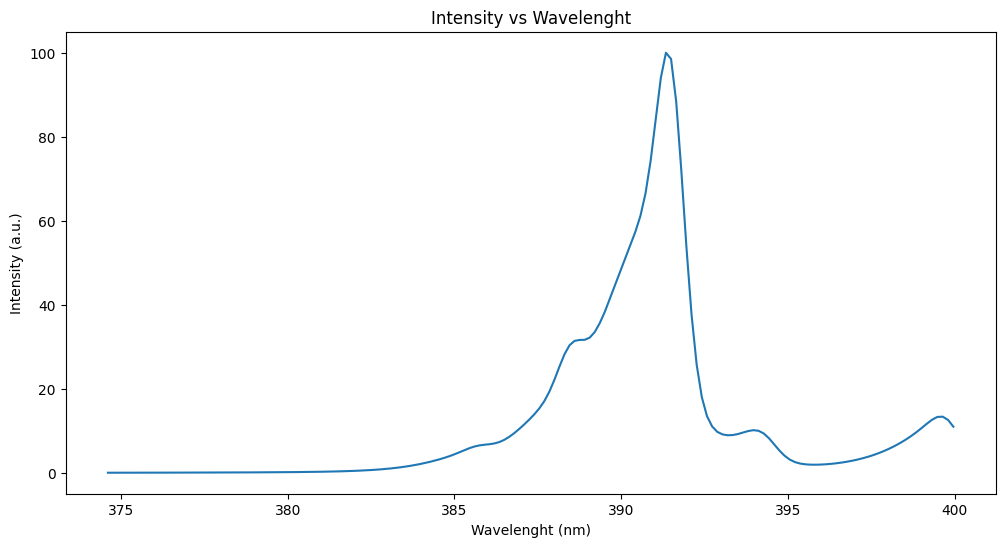

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.xlabel('Wavelenght (nm)')
plt.ylabel('Intensity (a.u.)')
plt.title('Intensity vs Wavelenght')

plt.show()

## Interative Graph

In [37]:
px.line(x=x,y=y)

# **Comparison Between Synthetic and Experimental Spectra**

## Estimation of the Concentration Ratio $[N_2^+]/[N_2]$

Here we isolate the ratio present in the equation for $\alpha$ proposed by [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).


In [38]:
# Partition Functions
QN2 = Calcular_Q(50, **Quantidades_SSP)
QN2Mais = Calcular_Q(50, **Quantidades_PSN)

# Estimated Ratio
Razao_Estimada = Razao_das_Concentracoes(alpha, QN2, QN2Mais, k * TEMP_ELE)


## Comparison

Finally, here we compare the experimental spectrum with the calculated one.


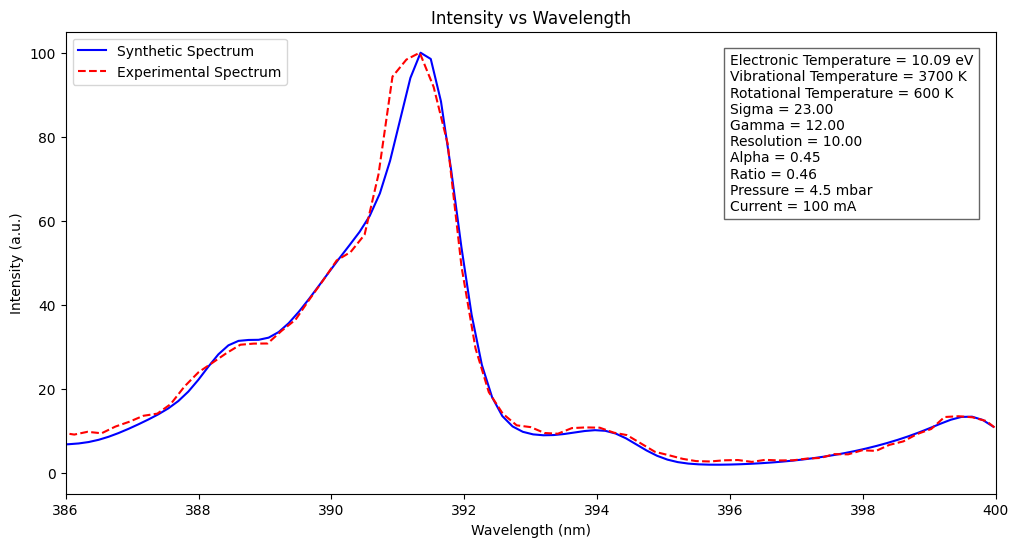

In [39]:
# Separate columns (1st: wavelength in nm, 2nd: intensity)
if Comp_de_Onda:
    x2 = dados_experimento.iloc[:, 0].values  # First column (Wavelength)
else:
    x2 = 1e+7 / dados_experimento.iloc[:, 0].astype(float).values  # First column (Wavenumber)
y2 = dados_experimento.iloc[:, 1].values  # Second column

# Filter experimental spectrum data for the range 385 nm to 401 nm
mask2 = (x2 >= 385) & (x2 <= 401)
x2 = (x2[mask2] + 0)  # Add zero to calibrate, if x axis is off-calibration
y2 = y2[mask2]

# Normalize experimental spectrum so max intensity = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

# Plot both spectra
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Synthetic Spectrum', color='b')
plt.plot(x2, y2, label='Experimental Spectrum', color='r', linestyle='--')

# Axis labels
if Comp_de_Onda:
    plt.xlabel('Wavelength (nm)')
else:
    plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')

# Title adjustments depending on data type
if Comp_de_Onda:
    plt.title('Intensity vs Wavelength')
else:
    plt.title('Intensity vs Wavelength')

# Limit graph to this region
plt.xlim(386, 400)
plt.legend()

# Display adjusted or calculated values
valores = (
    f"Electronic Temperature = {Te_eV:.2f} eV\n"
    f"Vibrational Temperature = {TEMP_V:.0f} K\n"
    f"Rotational Temperature = {TEMP_R:.0f} K\n"
    f"Sigma = {Sigma:.2f}\n"
    f"Gamma = {Gamma:.2f}\n"
    f"Resolution = {Resolucao:.2f}\n"
    f"Alpha = {alpha:.2f}\n"
    f"Ratio = {Razao_Estimada:.2f}\n"
    f"Pressure = {Pressao:.1f} mbar\n"
    f"Current = {Corrente} mA"
)

# Legend showing the variable "valores"
plt.text(396, max(y2) * 0.625, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()


# **Table with the Final Results**

Here, we generate a table in a *.dat* file with the final results of the program, such as an estimate for the real parameters of the experimental spectrum.


## Uncertainties

We estimate the uncertainties based on the calculations we performed as well as on the adjustments made, considering the sensitivity of each parameter to changes in values.


In [40]:
if Razao <= 12.172033905486556:
  erro_Te_eV = erro_interpolado  # Calculated Error at the Beginning
else:
  erro_Te_eV = erro_ajustado  # Calculated Error at the Beginning

erro_TEMP_V = 100  # Tv is not very sensitive to small variations

erro_TEMP_R = 50  # Tr is sensitive to small variations

erro_Sigma = 1  # A change of one unit significantly alters the spectral profile

erro_Gamma = 1  # A change of one unit significantly alters the spectral profile

erro_alpha = 0.05  # This variation is already significant

erro_Razao = Razao_das_Concentracoes(erro_alpha, QN2, QN2Mais, k * TEMP_ELE)  # Apply function with erro_alpha

erro_pressao = 0.1

erro_corrente = 1


## Table

Includes both values and their uncertainties.


In [41]:
dados = [
    ("Te", f"{Te_eV:.2f} eV", f"{erro_Te_eV:.2f}"),
    ("Tv", f"{TEMP_V:.0f} K", f"{erro_TEMP_V:.0f}"),
    ("Tr", f"{TEMP_R:.0f} K", f"{erro_TEMP_R:.0f}"),
    ("Sigma", f"{Sigma:.0f}", f"{erro_Sigma:.0f}"),
    ("Gamma", f"{Gamma:.0f}", f"{erro_Gamma:.0f}"),
    ("Alpha", f"{alpha:.2f}", f"{erro_alpha:.2f}"),
    ("Ratio", f"{Razao_Estimada:.2f}", f"{erro_Razao:.2f}"),
    ("Pressure", f"{Pressao:.1f} mbar", f"{erro_pressao}"),
    ("Current", f"{Corrente} mA", f"{erro_corrente}")
]

# Path of the .dat file
caminho_arquivo = f"Tabela_({Pressao}mbar)_({Corrente}mA).dat"

# Writing to the file
with open(caminho_arquivo, "w") as file:
    # Writes the table header with formatting for alignment
    file.write(f"{'Parâmetro':<25} {'Valor':<15} {'Incerteza':<12}\n")
    file.write("="*55 + "\n")  # Separator line

    # Writes the table rows with the correct format
    for parametro, valor, incerteza in dados:
        file.write(f"{parametro:<25} {valor:<15} {'+- ' + incerteza:<12}\n")

print(f"File '{caminho_arquivo}' generated successfully!")


File 'Tabela_(4.5mbar)_(100mA).dat' generated successfully!


# **Examples of Data Processing**

## Studies for Fixed Current

### Electronic Temperature

Hollow Cathode with diameter of $10.9$ mm

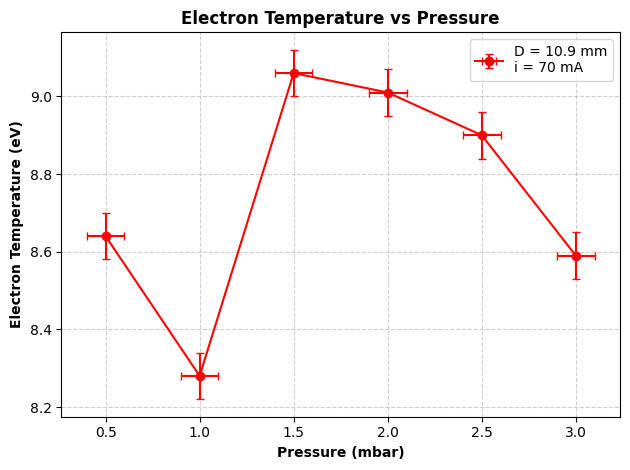

In [42]:
# X-axis data
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Dataset 1 (Electron temperature)
y1 = [8.64, 8.28, 9.06, 9.01, 8.90, 8.59]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [0.06] * len(y1)  # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')

# Plot settings
plt.title('Electron Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Electron Temperature (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Hollow Cathode with diameter of $6.4$ mm

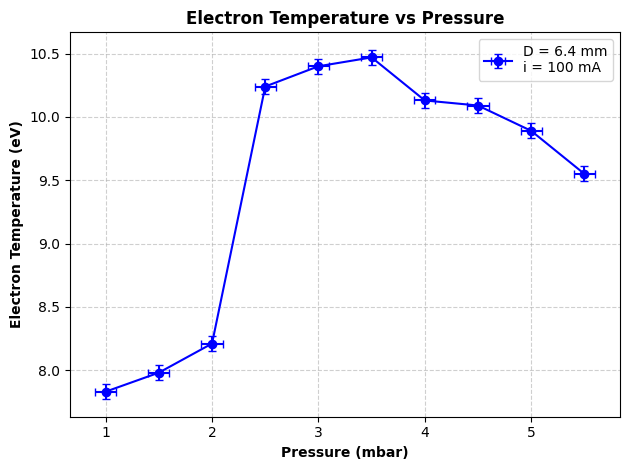

In [43]:
# X-axis data
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Dataset 1 (Electron temperature)
y1 = [7.83, 7.98, 8.21, 10.24, 10.40, 10.47, 10.13, 10.09, 9.89, 9.55]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [0.06] * len(y1)   # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')

# Plot settings
plt.title('Electron Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Electron Temperature (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Hollow Cathode with diameter of $4.0$ mm

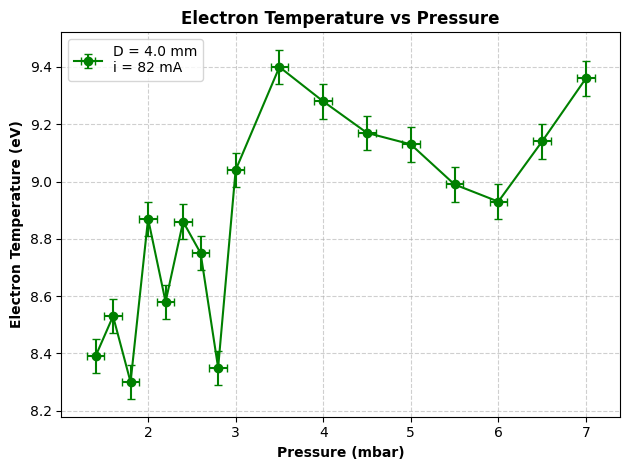

In [44]:
# X-axis data
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Dataset 1 (Electron temperature)
y1 = [8.39, 8.53, 8.30, 8.87, 8.58, 8.86, 8.75, 8.35, 9.04, 9.40, 9.28, 9.17, 9.13, 8.99, 8.93, 9.14, 9.36]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [0.06] * len(y1)   # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')

# Plot settings
plt.title('Electron Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Electron Temperature (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Bar Plot

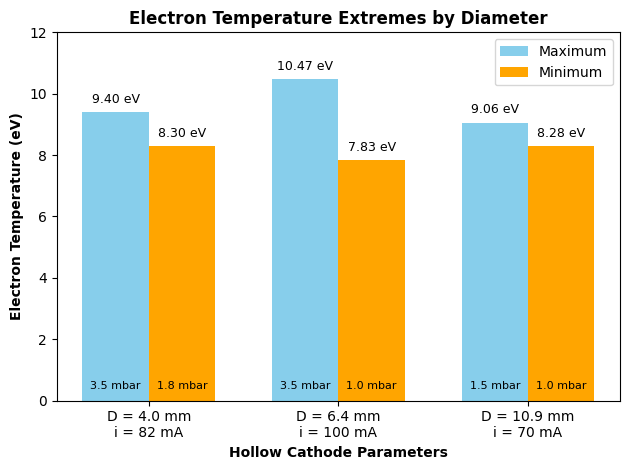

In [45]:
# Data
correntes = [82, 100, 70]  # Correntes (mA)
categorias = [
    f'D = 4.0 mm\ni = {correntes[0]} mA',
    f'D = 6.4 mm\ni = {correntes[1]} mA',
    f'D = 10.9 mm\ni = {correntes[2]} mA'
]

valores1 = [9.40, 10.47, 9.06]
valores2 = [8.30, 7.83, 8.28]

pressoes1 = [3.5, 3.5, 1.5]
pressoes2 = [1.8, 1.0, 1.0]

x = np.arange(len(categorias))
largura = 0.35

bars1 = plt.bar(x - largura/2, valores1, largura, label='Maximum', color='skyblue')
bars2 = plt.bar(x + largura/2, valores2, largura, label='Minimum', color='orange')

for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{bar.get_height():.2f} eV', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 0.3,
             f'{pressoes1[i]} mbar', ha='center', va='bottom', fontsize=8)

for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{bar.get_height():.2f} eV', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 0.3,
             f'{pressoes2[i]} mbar', ha='center', va='bottom', fontsize=8)

plt.title('Electron Temperature Extremes by Diameter', fontweight='bold')
plt.xlabel('Hollow Cathode Parameters', fontweight='bold')
plt.ylabel('Electron Temperature (eV)', fontweight='bold')
plt.xticks(x, categorias)
plt.ylim(0, 12)
plt.legend()
plt.tight_layout()
plt.show()


### Vibrational Temperature

Hollow Cathode with diameter of $10.9$ mm

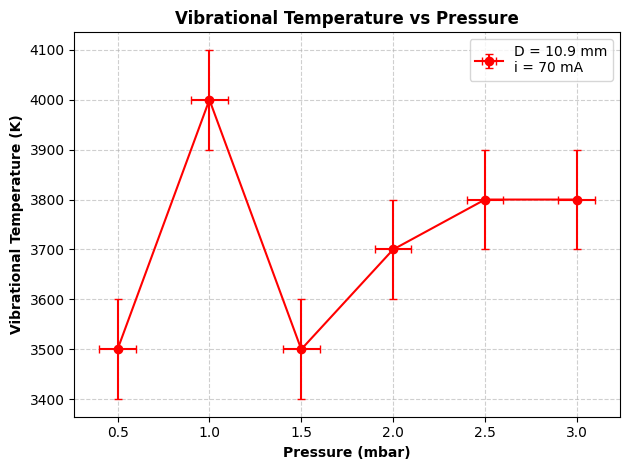

In [46]:
# X-axis data
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Dataset 1 (Vibrational temperature)
y1 = [3500, 4000, 3500, 3700, 3800, 3800]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±100 K)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [100] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')

# Plot settings
plt.title('Vibrational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Vibrational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


Hollow Cathode with diameter of $6.4$ mm

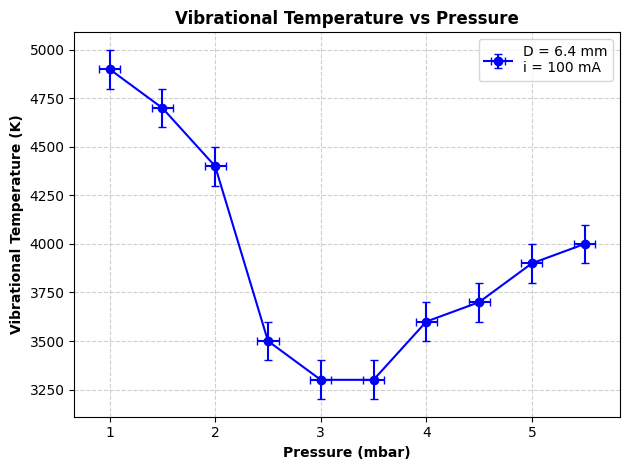

In [47]:
# X-axis data
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Dataset 1 (Vibrational temperature)
y1 = [4900, 4700, 4400, 3500, 3300, 3300, 3600, 3700, 3900, 4000]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [100] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')

# Plot settings
plt.title('Vibrational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Vibrational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


Hollow Cathode with diameter of $4.0$ mm

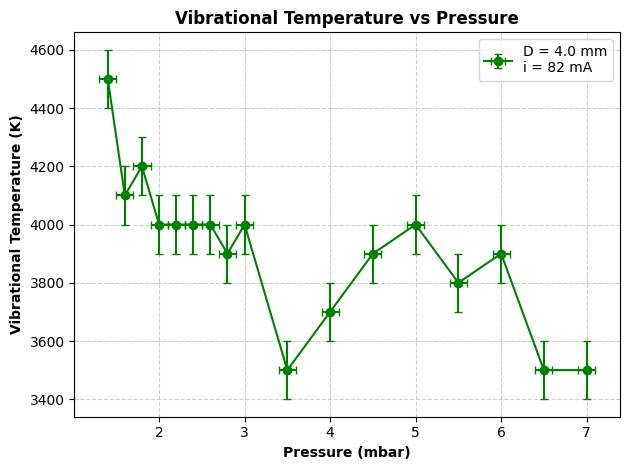

In [48]:
# X-axis data
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Dataset 1 (Vibrational temperature)
y1 = [4500, 4100, 4200, 4000, 4000, 4000, 4000, 3900, 4000, 3500, 3700, 3900, 4000, 3800, 3900, 3500, 3500]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [100] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')

# Plot settings
plt.title('Vibrational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Vibrational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


### Rotational Temperature

Hollow Cathode with diameter of $10.9$ mm

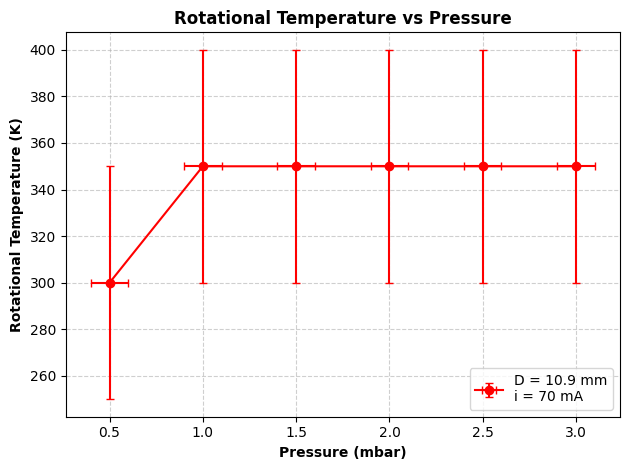

In [49]:
# X-axis data
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Dataset 1 (Rotational temperature)
y1 = [300, 350, 350, 350, 350, 350]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [50] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')

# Plot settings
plt.title('Rotational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Rotational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


Hollow Cathode with diameter of $6.4$ mm

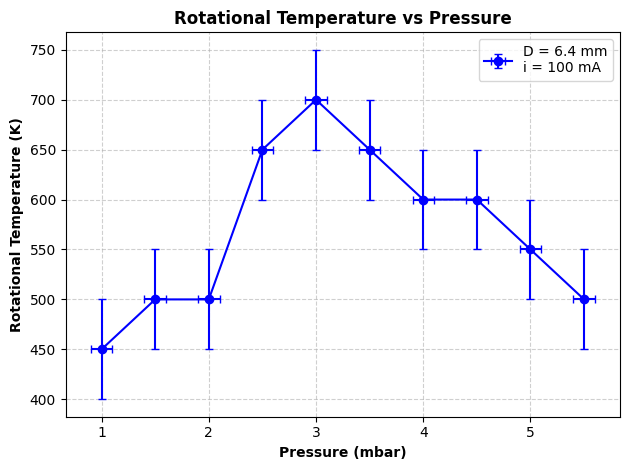

In [50]:
# X-axis data
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Dataset 1 (Rotational temperature)
y1 = [450, 500, 500, 650, 700, 650, 600, 600, 550, 500]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [50] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')

# Plot settings
plt.title('Rotational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Rotational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


Hollow Cathode with diameter of $4.0$ mm

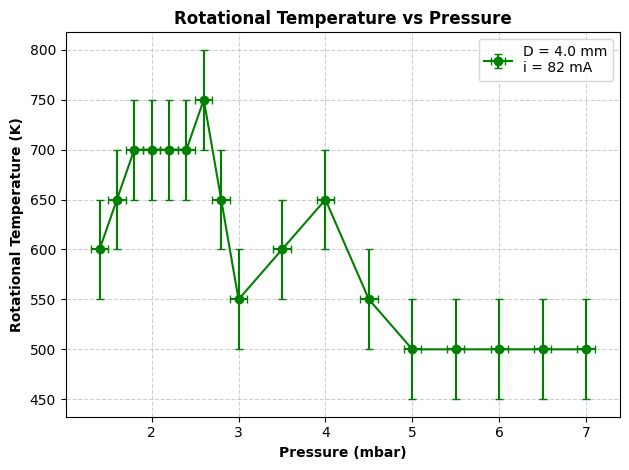

In [51]:
# X-axis data
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Dataset 1 (Rotational temperature)
y1 = [600, 650, 700, 700, 700, 700, 750, 650, 550, 600, 650, 550, 500, 500, 500, 500, 500]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [0.1] * len(x)     # same uncertainty for all x points
yerr = [50] * len(y1)     # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')

# Plot settings
plt.title('Rotational Temperature vs Pressure', fontweight='bold')
plt.xlabel('Pressure (mbar)', fontweight='bold')
plt.ylabel('Rotational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


## Studies for Fixed Pressure

### Electronic Temperature vs Current

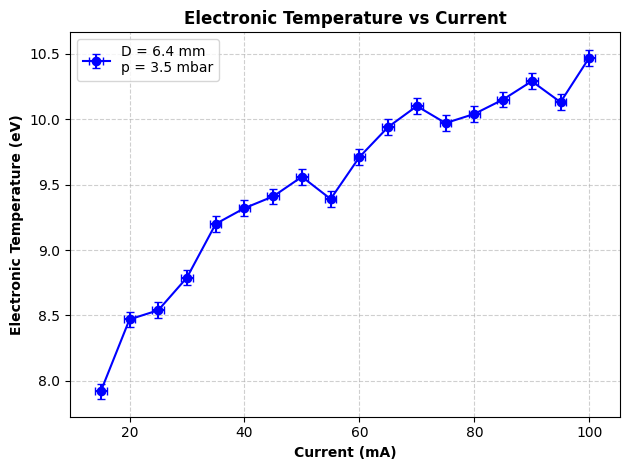

In [52]:
# X-axis data
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Dataset 1 (Electronic temperature)
y1 = [7.92, 8.47, 8.54, 8.79, 9.20, 9.32, 9.41, 9.56, 9.39, 9.71, 9.94, 10.10, 9.97, 10.04, 10.15, 10.29, 10.13, 10.47]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [1] * len(x)     # same uncertainty for all x points
yerr = [0.06] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Plot settings
plt.title('Electronic Temperature vs Current', fontweight='bold')
plt.xlabel('Current (mA)', fontweight='bold')
plt.ylabel('Electronic Temperature (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


### Vibrational Temperature vs Current

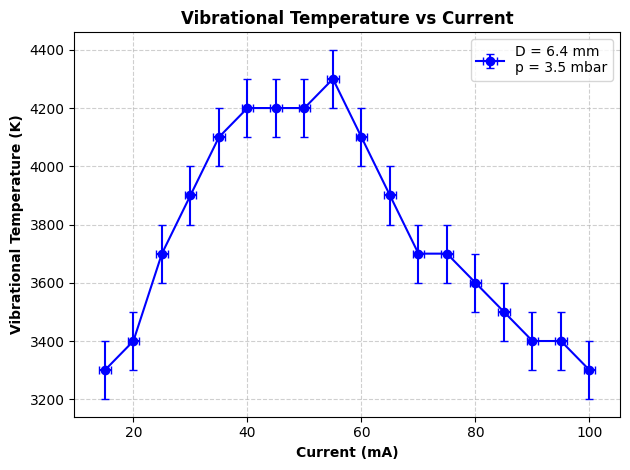

In [53]:
# X-axis data
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Dataset 1 (Vibrational temperature)
y1 = [3300, 3400, 3700, 3900, 4100, 4200, 4200, 4200, 4300, 4100, 3900, 3700, 3700, 3600, 3500, 3400, 3400, 3300]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [1] * len(x)     # same uncertainty for all x points
yerr = [100] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Plot settings
plt.title('Vibrational Temperature vs Current', fontweight='bold')
plt.xlabel('Current (mA)', fontweight='bold')
plt.ylabel('Vibrational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


### Rotational Temperature vs Current

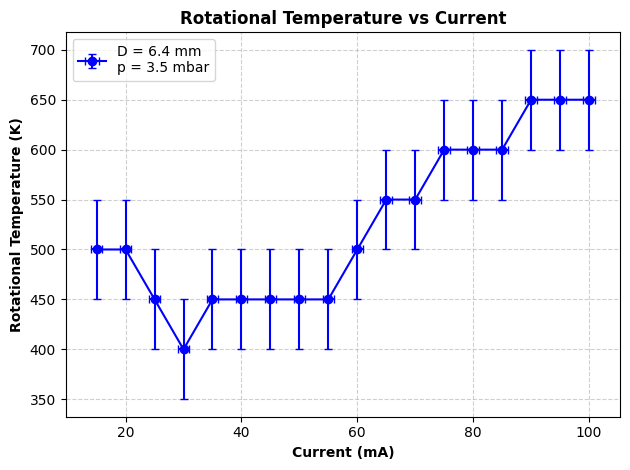

In [54]:
# X-axis data
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Dataset 1 (Rotational temperature)
y1 = [500, 500, 450, 400, 450, 450, 450, 450, 450, 500, 550, 550, 600, 600, 600, 650, 650, 650]

# Uncertainties in X and Y data (example: ±0.1 mbar and ±0.2 eV)
xerr = [1] * len(x)     # same uncertainty for all x points
yerr = [50] * len(y1)    # same uncertainty for all y points

# Plot with error bars
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Plot settings
plt.title('Rotational Temperature vs Current', fontweight='bold')
plt.xlabel('Current (mA)', fontweight='bold')
plt.ylabel('Rotational Temperature (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()
